In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px


incidents = pd.read_csv("C:\VS Code\LA_Fires\mapdataall.csv")

#southern cali counties
socal_counties = np.array([
    "Los Angeles","San Diego","Orange",
    "Riverside","San Bernardino","Ventura",
    "Santa Barbara","San Luis Obispo","Imperial",
    "Kern","Mono"
])

#standardize and replace counties
std_counties = incidents['incident_county'].str.strip().str.lower()
incidents['std_incident_county'] = std_counties
socal_counties = [county.strip().lower() for county in socal_counties]

#query incident df --> socal_incident df
#NIFC says a wildfire is atleast 100 acres

def is_socal(county):
    return county in socal_counties
def acres100(size):
    return size>=100
    
socal_incidents = incidents[incidents['std_incident_county'].apply(is_socal)]
socal_incidents = socal_incidents[socal_incidents['incident_acres_burned'].apply(acres100)]

socal_incidents = socal_incidents.drop(columns = ['incident_is_final', 'incident_date_last_update', 'incident_administrative_unit',
       'incident_administrative_unit_url',
       'incident_location', 'incident_containment',
       'incident_control', 'incident_cooperating_agencies', 'incident_type',
       'incident_url', 'incident_dateonly_extinguished', 'incident_dateonly_created',
       'is_active', 'calfire_incident', 'notification_desired',
       'std_incident_county'])

#organize by dates
def year_month(date):
    return date[:7].replace('-','_')

date_created = np.sort(socal_incidents['incident_date_created'].apply(year_month))

def correct_years(date):
    year = int(date[:4])
    if (year>=2014)and(year<2025):
        return True
    else:
        return False

socal_incidents = socal_incidents.drop(columns='incident_date_created')
socal_incidents['date_created'] = date_created
socal_incidents = socal_incidents[socal_incidents['date_created'].apply(correct_years)].set_index('incident_id')

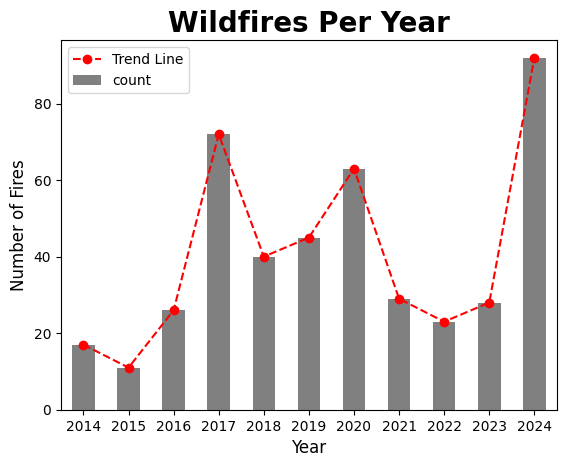

In [5]:

#plotting
socal_incidents['Year'] = socal_incidents['date_created'].str[:4]
filtered_years = socal_incidents['Year'].value_counts().sort_index()

ax = filtered_years.plot(kind='bar', color='grey', title='Wildfires Per Year')
plt.xticks(rotation=0)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Number of Fires', fontsize=12)
plt.title('Wildfires Per Year', fontsize=20, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.plot(filtered_years.index, filtered_years.values, color='red', marker='o', linestyle='--', label='Trend Line')

plt.legend()
plt.show()

In [17]:
# Filter for incidents in Los Angeles County only (case insensitive)
la_incidents = incidents[incidents['std_incident_county'] == 'los angeles']

# Drop irrelevant columns (same as in socal_incidents)
la_incidents = la_incidents.drop(columns=[
    'incident_is_final', 'incident_date_last_update', 'incident_administrative_unit',
    'incident_administrative_unit_url', 'incident_location', 'incident_containment',
    'incident_control', 'incident_cooperating_agencies', 'incident_type',
    'incident_url', 'incident_dateonly_extinguished', 'incident_dateonly_created',
    'is_active', 'calfire_incident', 'notification_desired', 'std_incident_county'
])

# Organize by dates
def year_month(date):
    return date[:7].replace('-', '_')

# Create a new column for formatted date
la_incidents['date_created'] = la_incidents['incident_date_created'].apply(year_month)

# Filter for years 2014–2024
def correct_years(date):
    year = int(date[:4])
    return (year >= 2014) and (year < 2025)

la_incidents = la_incidents[la_incidents['date_created'].apply(correct_years)]

# Set 'incident_id' as the index
la_fires = la_incidents.set_index('incident_id')

# Resetting index if needed (optional)
# la_incidents.reset_index(inplace=True)

la_fires['Year'] = la_fires['date_created'].str.split('_').str[0]  # Extract Year
la_fires['Month'] = la_fires['date_created'].str.split('_').str[1]
la_fires= la_fires.drop(columns=['e','incident_county','incident_longitude','incident_date_created','incident_latitude','incident_date_extinguished','date_created'])  # Extract Month

def dry_months(month):
    month = int(month)  # Convert to integer
    if month == 7:
        return 'July'
    elif month == 8:
        return 'August'
    elif month == 9:
        return 'September'
    elif month == 10:
        return 'October'
    elif month == 11:
        return 'November'
    elif month == 12:
        return 'December'
    else:
        return None  # Return None for months outside July–December

# Apply function to filter and map months
la_fires['Month_Name'] = la_fires['Month'].apply(dry_months)

# Drop rows where 'Month_Name' is None (optional)
la_fires = la_fires.dropna(subset=['Month_Name']).drop(columns=['Month'])

la_fires.groupby(['Year','Month_Name']).sum().reset_index()

,incident_acres_burned,Year,Month_Name
incident_id,,,
accb599e-35b8-4d5e-8d13-d0e4b0e4a1eb,190.0,2014,August
d805c9b9-da39-4771-965f-b3cd4c37c84b,274.0,2014,August
0c9948a7-98ad-4b42-888e-a7c2a4f536fa,200.0,2015,July
79b446a4-d809-4aa2-9f30-091a05ed697d,1100.0,2016,July
ca1227b3-1458-44c9-b32e-2994e309f940,4824.0,2016,November
...,...,...,...
9a4f6a74-807d-4be5-bb55-c072f7600b83,13.0,2024,September
a32d77be-a62d-444a-9872-68f997469297,25.0,2024,October
698b289b-437c-4961-b187-c1f03a8edbe6,50.0,2024,November


In [7]:
pivoted_data = la_fires.groupby(['Year', 'Month_Name'])['incident_acres_burned'].sum().unstack()
pivoted_data = pivoted_data.fillna(0)
pivoted_data.columns.name = None  # Remove the 'Month_Name' label
pivoted_data = pivoted_data.reset_index()
pivoted_data.index.name = 'Year'
pivoted_data.set_index('Year')
pivoted_data.columns = ['Year', 'July', 'August', 'September', 'October', 'November', 'December']
pivoted_data

,Year,July,August,September,October,November,December
Year,,,,,,,
0,2014,464.0,0.0,0.0,0.0,0.0,0.0
1,2015,0.0,0.0,200.0,0.0,0.0,0.0
2,2016,0.0,0.0,1100.0,4824.0,0.0,0.0
3,2017,40.0,22090.0,135.0,0.0,50.0,7194.0
4,2018,0.0,0.0,128.0,0.0,0.0,3546.0
5,2019,1731.0,0.0,0.0,0.0,14201.0,0.0
6,2020,36324.0,0.0,2714.0,131.0,0.0,230.0
7,2021,50.0,0.0,1208.0,0.0,0.0,464.0
8,2022,5673.0,0.0,0.0,0.0,0.0,0.0


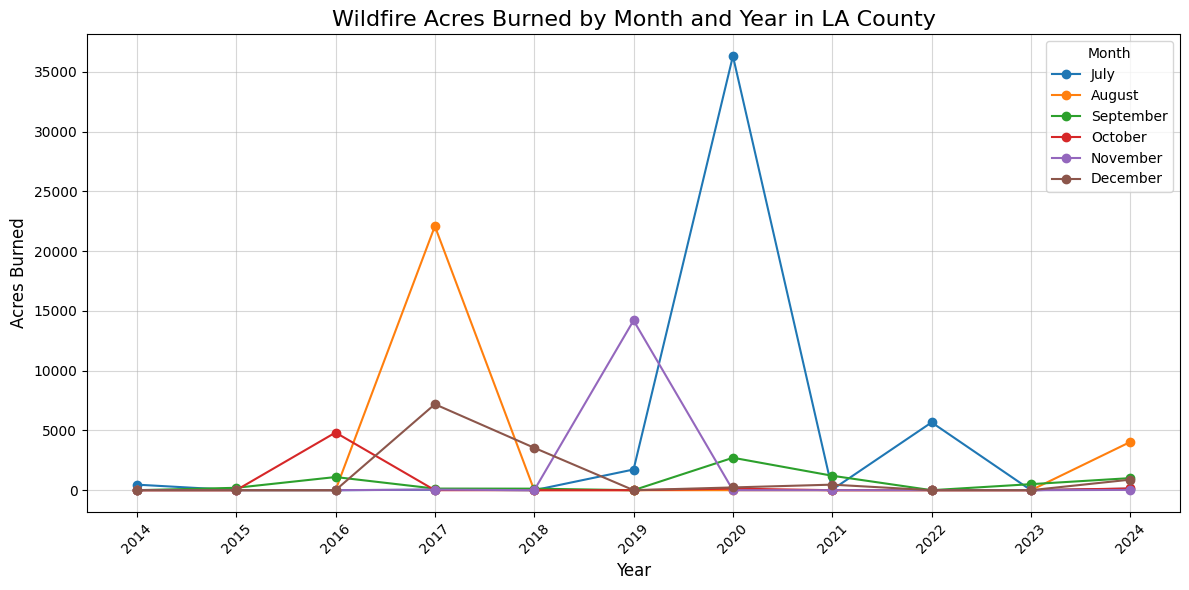

In [8]:
import matplotlib.pyplot as plt

# Assuming your pivoted data is in a DataFrame named pivoted_data
# Reset index to have 'Year' as a column (if it's not already)
# pivoted_data = pivoted_data.reset_index()

# Plot the data
plt.figure(figsize=(12, 6))  # Set the figure size

# Loop through each month and plot its data
for month in ['July', 'August', 'September', 'October', 'November', 'December']:
    plt.plot(pivoted_data['Year'], pivoted_data[month], marker='o', label=month)

# Customize the plot
plt.title('Wildfire Acres Burned by Month and Year in LA County', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Acres Burned', fontsize=12)
plt.xticks(rotation=45)  # Rotate year labels for better visibility
plt.legend(title='Month', fontsize=10)  # Add a legend for months
plt.grid(alpha=0.5)  # Add grid lines
plt.tight_layout()  # Adjust layout to prevent clipping

# Show the plot
plt.show()


In [9]:
pivoted_data.to_csv('la_fires_incidents.csv',index=False)